Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Train distribution: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Test distribution: {'glioma': 241, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


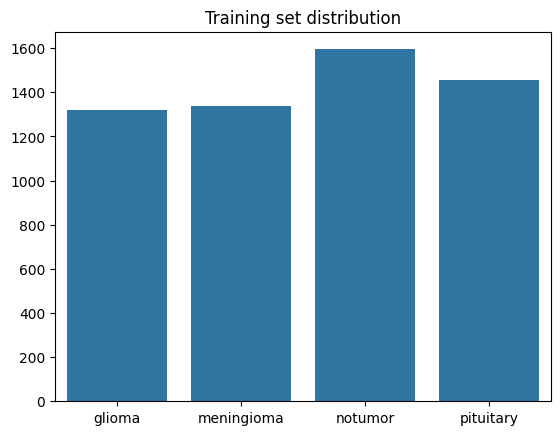

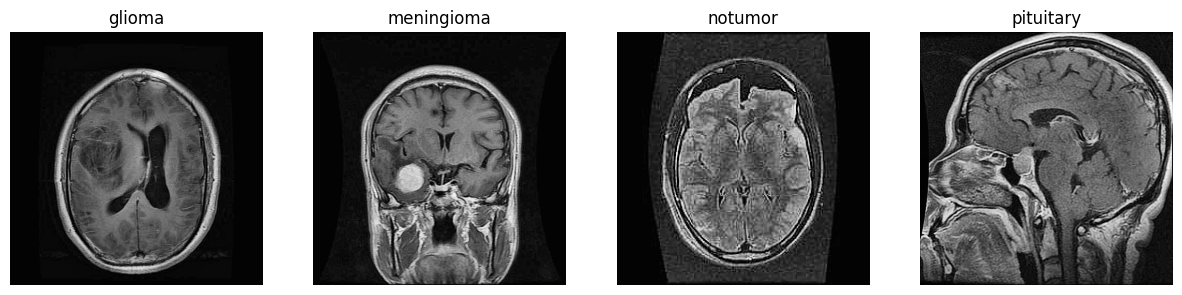

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

# Paths
train_dir = "../DATASET/classification/Training"
test_dir = "../DATASET/classification/Testing"

# Check class distribution
# Each class is a folder (e.g., glioma, meningioma, pituitary, notumor).
# os.listdir(train_dir) gives the list of class names.
classes = os.listdir(train_dir)
print("Classes:", classes)

# Count images per class
# This helps us check if dataset is balanced or imbalanced.
# Imbalanced data can cause bias in training, so this insight is important
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in classes}

print("Train distribution:", train_counts)
print("Test distribution:", test_counts)

# Plot distribution
# Using seaborn barplot to show how many images are in each class (train set).
# This gives quick insight into dataset balance.
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Training set distribution")
plt.show()

# Show random images from each class
#   - Check image quality
#   - Confirm correct labeling
#   - Get a feel for what the data looks like
fig, axs = plt.subplots(1, len(classes), figsize=(15, 5))
for i, cls in enumerate(classes):
    img_path = os.path.join(train_dir, cls, random.choice(os.listdir(os.path.join(train_dir, cls))))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].set_title(cls)
    axs[i].axis("off")
plt.show()


In [3]:
# 6. Check image shapes (resolution consistency)
# -------------------------
shapes = []
for cls in classes:
    for img_file in os.listdir(os.path.join(train_dir, cls))[:50]:  # check first 50 per class
        img_path = os.path.join(train_dir, cls, img_file)
        img = cv2.imread(img_path)
        shapes.append(img.shape[:2])  # store height, width
shapes = list(set(shapes))  # unique shapes
print("Unique image shapes found:", shapes)


Unique image shapes found: [(613, 605), (452, 355), (903, 721), (630, 630), (350, 350), (502, 502), (378, 360), (741, 900), (449, 359), (442, 442), (1365, 1365), (442, 332), (236, 236), (280, 236), (212, 220), (400, 393), (512, 512), (218, 236), (244, 206), (432, 470), (224, 234), (501, 411), (286, 224), (251, 236), (295, 236), (210, 201), (444, 468), (1280, 1280), (198, 254), (592, 562), (202, 202), (900, 940), (229, 235), (681, 685), (225, 225), (508, 470), (233, 235), (442, 400), (680, 680), (400, 400), (830, 1024), (474, 474)]


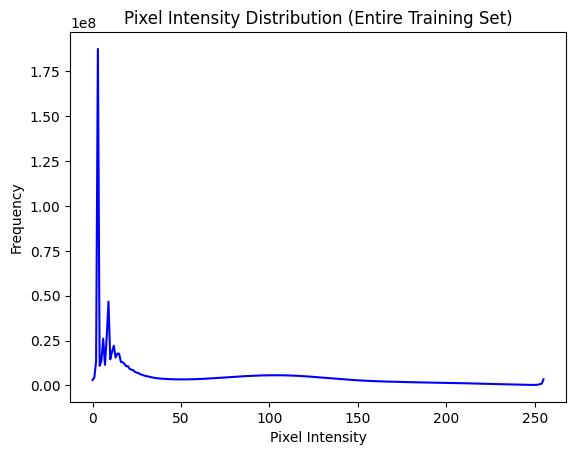

In [11]:
import numpy as np

# Initialize empty histogram
hist_total = np.zeros(256, dtype=np.int64)  # grayscale → 0-255

for cls in classes:
    folder = os.path.join(train_dir, cls)
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # Compute histogram for this image
            hist, _ = np.histogram(img, bins=256, range=(0, 256))
            hist_total += hist  # accumulate
            

# Plot combined histogram
plt.plot(hist_total, color="blue")
plt.title("Pixel Intensity Distribution (Entire Training Set)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


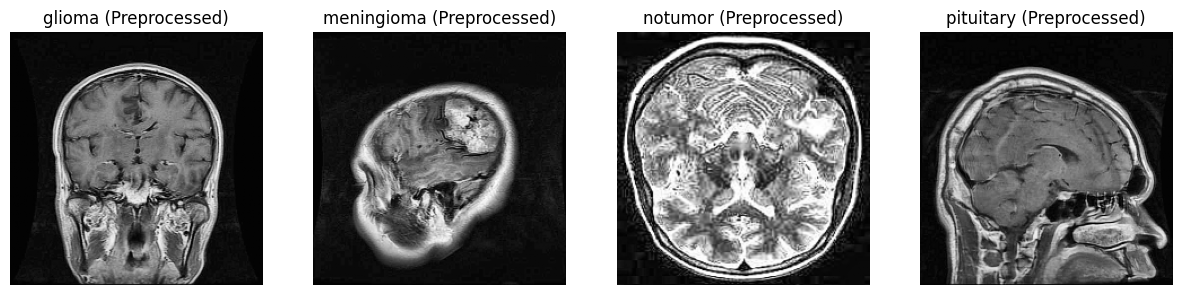

In [13]:
#  Preprocessing Function
# ===============================
# Here we define preprocessing for each image:
#   1. Convert to Grayscale → reduces complexity (MRI doesn’t need color info).
#   2. Resize to 224x224 → standard size for CNNs like VGG16/ResNet.
#   3. Normalize pixel values → scale between 0 and 1 for stable training.
def preprocess_image(img_path, target_size=(224, 224)):
    # Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize to fixed target size
    img = cv2.resize(img, target_size)
    
    # Normalize pixel values (0–255 → 0–1)
    img = img.astype("float32") / 255.0
    
    return img


# ===============================
# STEP 7: Apply preprocessing and visualize
# ===============================
# Let's check how preprocessing changes the image.
fig, axs = plt.subplots(1, len(classes), figsize=(15, 5))

for i, cls in enumerate(classes):
    img_path = os.path.join(train_dir, cls, random.choice(os.listdir(os.path.join(train_dir, cls))))
    
    # Apply preprocessing
    img = preprocess_image(img_path)
    
    # Show processed image
    axs[i].imshow(img, cmap="gray")  # since grayscale
    axs[i].set_title(f"{cls} (Preprocessed)")
    axs[i].axis("off")

plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# ======================================
# STEP 8: Dataset Loader
# N → number of samples (images in batch/dataset).

# H → image height (e.g., 224).

# W → image width (e.g., 224).

# C → number of channels:

# 1 → grayscale image (like MRI, black & white).

# 3 → RGB image (red, green, blue channels).

# 👉 CNNs process images using filters (kernels) that slide across each channel.
# If you don’t include C, the model won’t know whether your input is grayscale or RGB.
# ======================================
def load_dataset(data_dir, target_size=(224, 224)):
    """
    Loads all images from a given directory, applies preprocessing,
    and returns numpy arrays of images and labels.
    """
    images = []
    labels = []
    
    # Loop through each class folder
    for cls in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls)
        
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            
            # Preprocess each image (grayscale, resize, normalize)
            img = preprocess_image(img_path, target_size)
            
            images.append(img)
            labels.append(cls)
    
    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # CNN expects (samples, height, width, channels) → add channel dim (1 for grayscale)
    images = np.expand_dims(images, axis=-1)
    
    return images, labels


# ======================================
# STEP 9: Apply loader on train & test sets
# ======================================
X_train, y_train = load_dataset(train_dir)
X_test, y_test = load_dataset(test_dir)

print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# ======================================
# STEP 10: Encode labels into numbers
# ======================================
# Convert string labels into integers
# "Glioma" → [1, 0, 0, 0]

# "Meningioma" → [0, 1, 0, 0]

# "No Tumor" → [0, 0, 1, 0]

# "Pituitary" → [0, 0, 0, 1]
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

# One-hot encode (for classification with softmax)
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

print("Classes mapping:", dict(zip(encoder.classes_, range(len(encoder.classes_)))))
print("y_train one-hot shape:", y_train_cat.shape)
print("y_test one-hot shape:", y_test_cat.shape)


Train data shape: (5712, 224, 224, 1)
Test data shape: (1252, 224, 224, 1)
Classes mapping: {np.str_('glioma'): 0, np.str_('meningioma'): 1, np.str_('notumor'): 2, np.str_('pituitary'): 3}
y_train one-hot shape: (5712, 4)
y_test one-hot shape: (1252, 4)


In [ ]:
# 🔎 Explanation of Your Code & Results
# 1. Dataset Loader (load_dataset)

# Reads all images from your dataset folders (train_dir, test_dir).

# Applies preprocessing:

# Grayscale conversion → no color info needed for MRIs.

# Resize → 224×224 (standard for CNNs like VGG/ResNet).

# Normalize → pixels scaled [0–1].

# Adds channel dimension → shape becomes (N, H, W, C):

# N = number of images

# H = 224

# W = 224

# C = 1 (grayscale)

# ✅ Example: (5712, 224, 224, 1) means → 5712 training images, each 224×224 pixels, 1 channel.

# 2. Label Encoding

# Classes are text ("glioma", "meningioma", "notumor", "pituitary").

# LabelEncoder converts them into integers:

# glioma → 0

# meningioma → 1

# notumor → 2

# pituitary → 3

# ✅ Mapping: {‘glioma’: 0, ‘meningioma’: 1, ‘notumor’: 2, ‘pituitary’: 3}

# 3. One-Hot Encoding

# Converts integer labels into vectors for classification:

# glioma → [1, 0, 0, 0]

# meningioma → [0, 1, 0, 0]

# notumor → [0, 0, 1, 0]

# pituitary → [0, 0, 0, 1]

# ✅ Shapes:

# y_train one-hot shape: (5712, 4) → 5712 samples, 4 classes.

# y_test one-hot shape: (1252, 4)

# 4. Dataset Stats

# Train distribution: {glioma: 1321, meningioma: 1339, notumor: 1595, pituitary: 1457}

# Test distribution: {glioma: 241, meningioma: 306, notumor: 405, pituitary: 300}


# Balanced enough → good for training.

# Unique image shapes: many different original sizes (e.g., 613×605, 512×512, 224×234) → you resized them to a consistent 224×224, which CNN requires.

In [15]:
from sklearn.model_selection import train_test_split

# Split training into (train + validation)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_cat, test_size=0.2, random_state=42, stratify=y_train_cat
)

print("Train split:", X_train_split.shape)
print("Validation split:", X_val.shape)

Train split: (4569, 224, 224, 1)
Validation split: (1143, 224, 224, 1)
